In [1]:
import datetime as dt
import os

import arviz as az
import numpy as np
import numpyro
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)
from sklearn.gaussian_process import kernels
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayScaler
from src.step3_modeling.ensemble import DefaultEnsemble
from src.step3_modeling.gaussian_process import SklearnGPModel, LaggedGPModel
from src.step3_modeling.metrics import summarize
from src.step3_modeling.modeling import ModelBase, SklearnRegressorModel
from src.step3_modeling.nn import BayesNN
from src.utils import create_rnbs_snapshot, flatten_array

# device = "cuda"
device = "cpu"

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [2]:
def split_data(split_date, lake_data, validation_steps=12, num_years_ahead=1):
    covars = lake_data.sel(type="Basin")[["precip", "evap", "temp"]].to_array().transpose("Date", "lake", ...)
    y_scaler = XArrayScaler()
    y_vals = y_scaler.fit_transform(lake_data["rnbs"])
    lake_snapshot = create_rnbs_snapshot(rnbs_data=y_vals,
                                         covariates=covars,
                                         split_date=split_date,
                                         validation_steps=validation_steps, sequential_validation=True,
                                         num_years_forward=num_years_ahead)
    return lake_snapshot, y_scaler


lake_data = load_data(["rnbs", "precip", "evap", "temp"]).dropna("Date").transpose("Date", "lake", ...)

train_split = dt.datetime(1999, 12, 1)
snapshot, y_scaler = split_data(train_split, lake_data)

scaled_rnbs = XArrayScaler().fit_transform(lake_data["rnbs"])

snapshot.train_y

<xarray.DataArray 'rnbs' (Date: 240, lake: 4)>
array([[-1.18710356e+00, -4.79767891e-01,  1.18010055e-01,
         7.31526068e-01],
       [-3.96996869e-01, -4.91255064e-01,  5.88664558e-01,
        -4.76262581e-01],
       [ 1.14108578e+00,  2.22787517e+00,  1.79230574e+00,
         2.43288709e+00],
       [ 1.68939841e+00,  2.64999989e+00,  2.12747371e+00,
         2.32571709e+00],
       [ 2.74053276e+00,  1.54775618e+00,  6.15514984e-01,
         4.55629065e-01],
       [ 2.00538007e+00,  9.76609632e-01,  1.18318677e-01,
        -4.22121578e-01],
       [ 6.82073093e-01, -2.10286873e-01, -3.79495056e-01,
        -8.89365459e-01],
       [-1.35448004e-02,  5.11536952e-01, -4.27332080e-01,
        -8.89365459e-01],
       [-7.36880909e-02, -1.65610865e+00, -4.83502002e-01,
        -7.11367806e-01],
       [ 1.99399453e-01, -8.32659707e-01, -1.03007872e+00,
        -4.98512247e-01],
...
       [ 1.75738932e-01,  1.84611056e+00,  1.39047495e+00,
         2.30643457e+00],
       [ 1.36966346e-01,  1.30569910e+00,  1.48861797e+00,
         9.12861068e-01],
       [ 3.36630097e-01,  4.95497598e-01, -6.36624541e-03,
         1.87932380e-02],
       [ 9.42948620e-01,  2.56337677e-01, -1.96479854e-01,
        -1.05023124e-02],
       [-4.86753914e-01, -1.10534895e+00, -5.23006129e-01,
        -6.59451810e-01],
       [-7.32822781e-01, -6.49797638e-01, -6.47382439e-01,
        -9.46843892e-01],
       [-1.06284802e+00, -1.53813305e+00, -1.75195498e+00,
        -1.60135615e+00],
       [-1.05460497e+00, -1.67318399e+00, -1.69979679e+00,
        -1.72855032e+00],
       [-5.31632581e-01, -9.14104313e-01, -1.78898968e+00,
        -1.27873540e+00],
       [-1.08772972e+00, -1.44861652e+00, -1.03007872e+00,
        -1.18825324e+00]])
Coordinates:
  * Date     (Date) datetime64[ns] 1979-01-01 1979-02-01 ... 1998-12-01
  * lake     (lake) object 'sup' 'mic_hur' 'eri' 'ont'

In [3]:
preprocessor = Pipeline(steps=[
    ("scale", XArrayScaler()),
    ("flatten", FunctionTransformer(flatten_array))
])

all_models = {
    "Default": Pipeline(steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]),
    "GP_RQMatern": Pipeline(steps=[("preprocessor", preprocessor),
                                   ("model", SklearnGPModel(1.0 * kernels.Matern() * kernels.RationalQuadratic()))]),
    "GP_LagRQMatern": Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", LaggedGPModel(1.0 * kernels.Matern() * kernels.RationalQuadratic()))]),
    "EnsembleNN": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model",
         SklearnRegressorModel(
             sklearn_regressor=MLPRegressor(solver="lbfgs", hidden_layer_sizes=(100,), max_iter=1000,
                                            activation="relu"),
             n_estimators=250, n_jobs=-1)),
    ]),
    "LM": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", SklearnRegressorModel(sklearn_regressor=LinearRegression())),
    ]),
    "BNN": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", BayesNN())
    ]),
}



In [ ]:
def fit_model(fit_snapshot, model):
    model.fit(y=fit_snapshot.train_y, X=fit_snapshot.train_x)
    return model


def run_forecasts(start_date, fitted_model: ModelBase, num_years_ahead=10):
    rnbs = scaled_rnbs.rename("true")
    all_dfs = []
    for i in range(12 * num_years_ahead + 1):
        new_split = start_date + relativedelta(months=i)
        new_snapshot, _ = split_data(new_split, lake_data, validation_steps=0, num_years_ahead=1)
        predictions = fitted_model.predict(X=new_snapshot.test_x, y=new_snapshot.test_y, forecast_steps=12)

        months_ahead = xr.DataArray(np.arange(1, 13), dims="Date", coords={"Date": predictions.indexes["Date"]},
                                    name="months_ahead")
        merged_ds = xr.merge([predictions, rnbs, months_ahead]).dropna("Date")
        comparison_df = merged_ds.to_dataframe(["Date", "lake", "value"]).reset_index(
            names=["Date", "lake", "value"]).pivot(index=["Date", "lake", "months_ahead", "true"], columns="value",
                                                   values="forecasts").reset_index()
        all_dfs.append(comparison_df)
    return pd.concat(all_dfs)


snapshot, y_scaler = split_data(train_split, lake_data, num_years_ahead=10, validation_steps=0)
all_model_results = []
fitted_models = {}
for name, model in all_models.items():
    fitted_model = fit_model(snapshot, model)
    fitted_models.update({name: fitted_model})
    predictions = run_forecasts(train_split, model).assign(model=name)
    all_model_results.append(predictions)

results_df = pd.concat(all_model_results)
results_df.head()

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
results_df.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

In [ ]:
og = scaled_rnbs.to_dataframe(name="rnbs").reset_index()
result_subset = results_df[results_df["months_ahead"].isin([6])]

(
        ggplot(data=result_subset, mapping=aes(x="Date", y="mean"))
        + geom_line(data=og, mapping=aes(x="Date", y="rnbs"), inherit_aes=False)
        + geom_line(mapping=aes(x="Date", y="mean"), color="red")
        + facet_grid("model~lake")
        + scale_x_datetime(
    limits=[results_df.Date.min() - relativedelta(years=2), results_df.Date.max() + relativedelta(years=1)],
    labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"), fill="red", alpha=0.3,
)
        + theme_bw()
        + theme(figure_size=(12, 6))
)


In [7]:
model = fitted_models["BNN"].steps[-1][1]

In [8]:
az.plot_trace(model.trace)

array([[<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b2'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>],
       [<Axes: title={'center': 'w2'}>, <Axes: title={'center': 'w2'}>]],
      dtype=object)

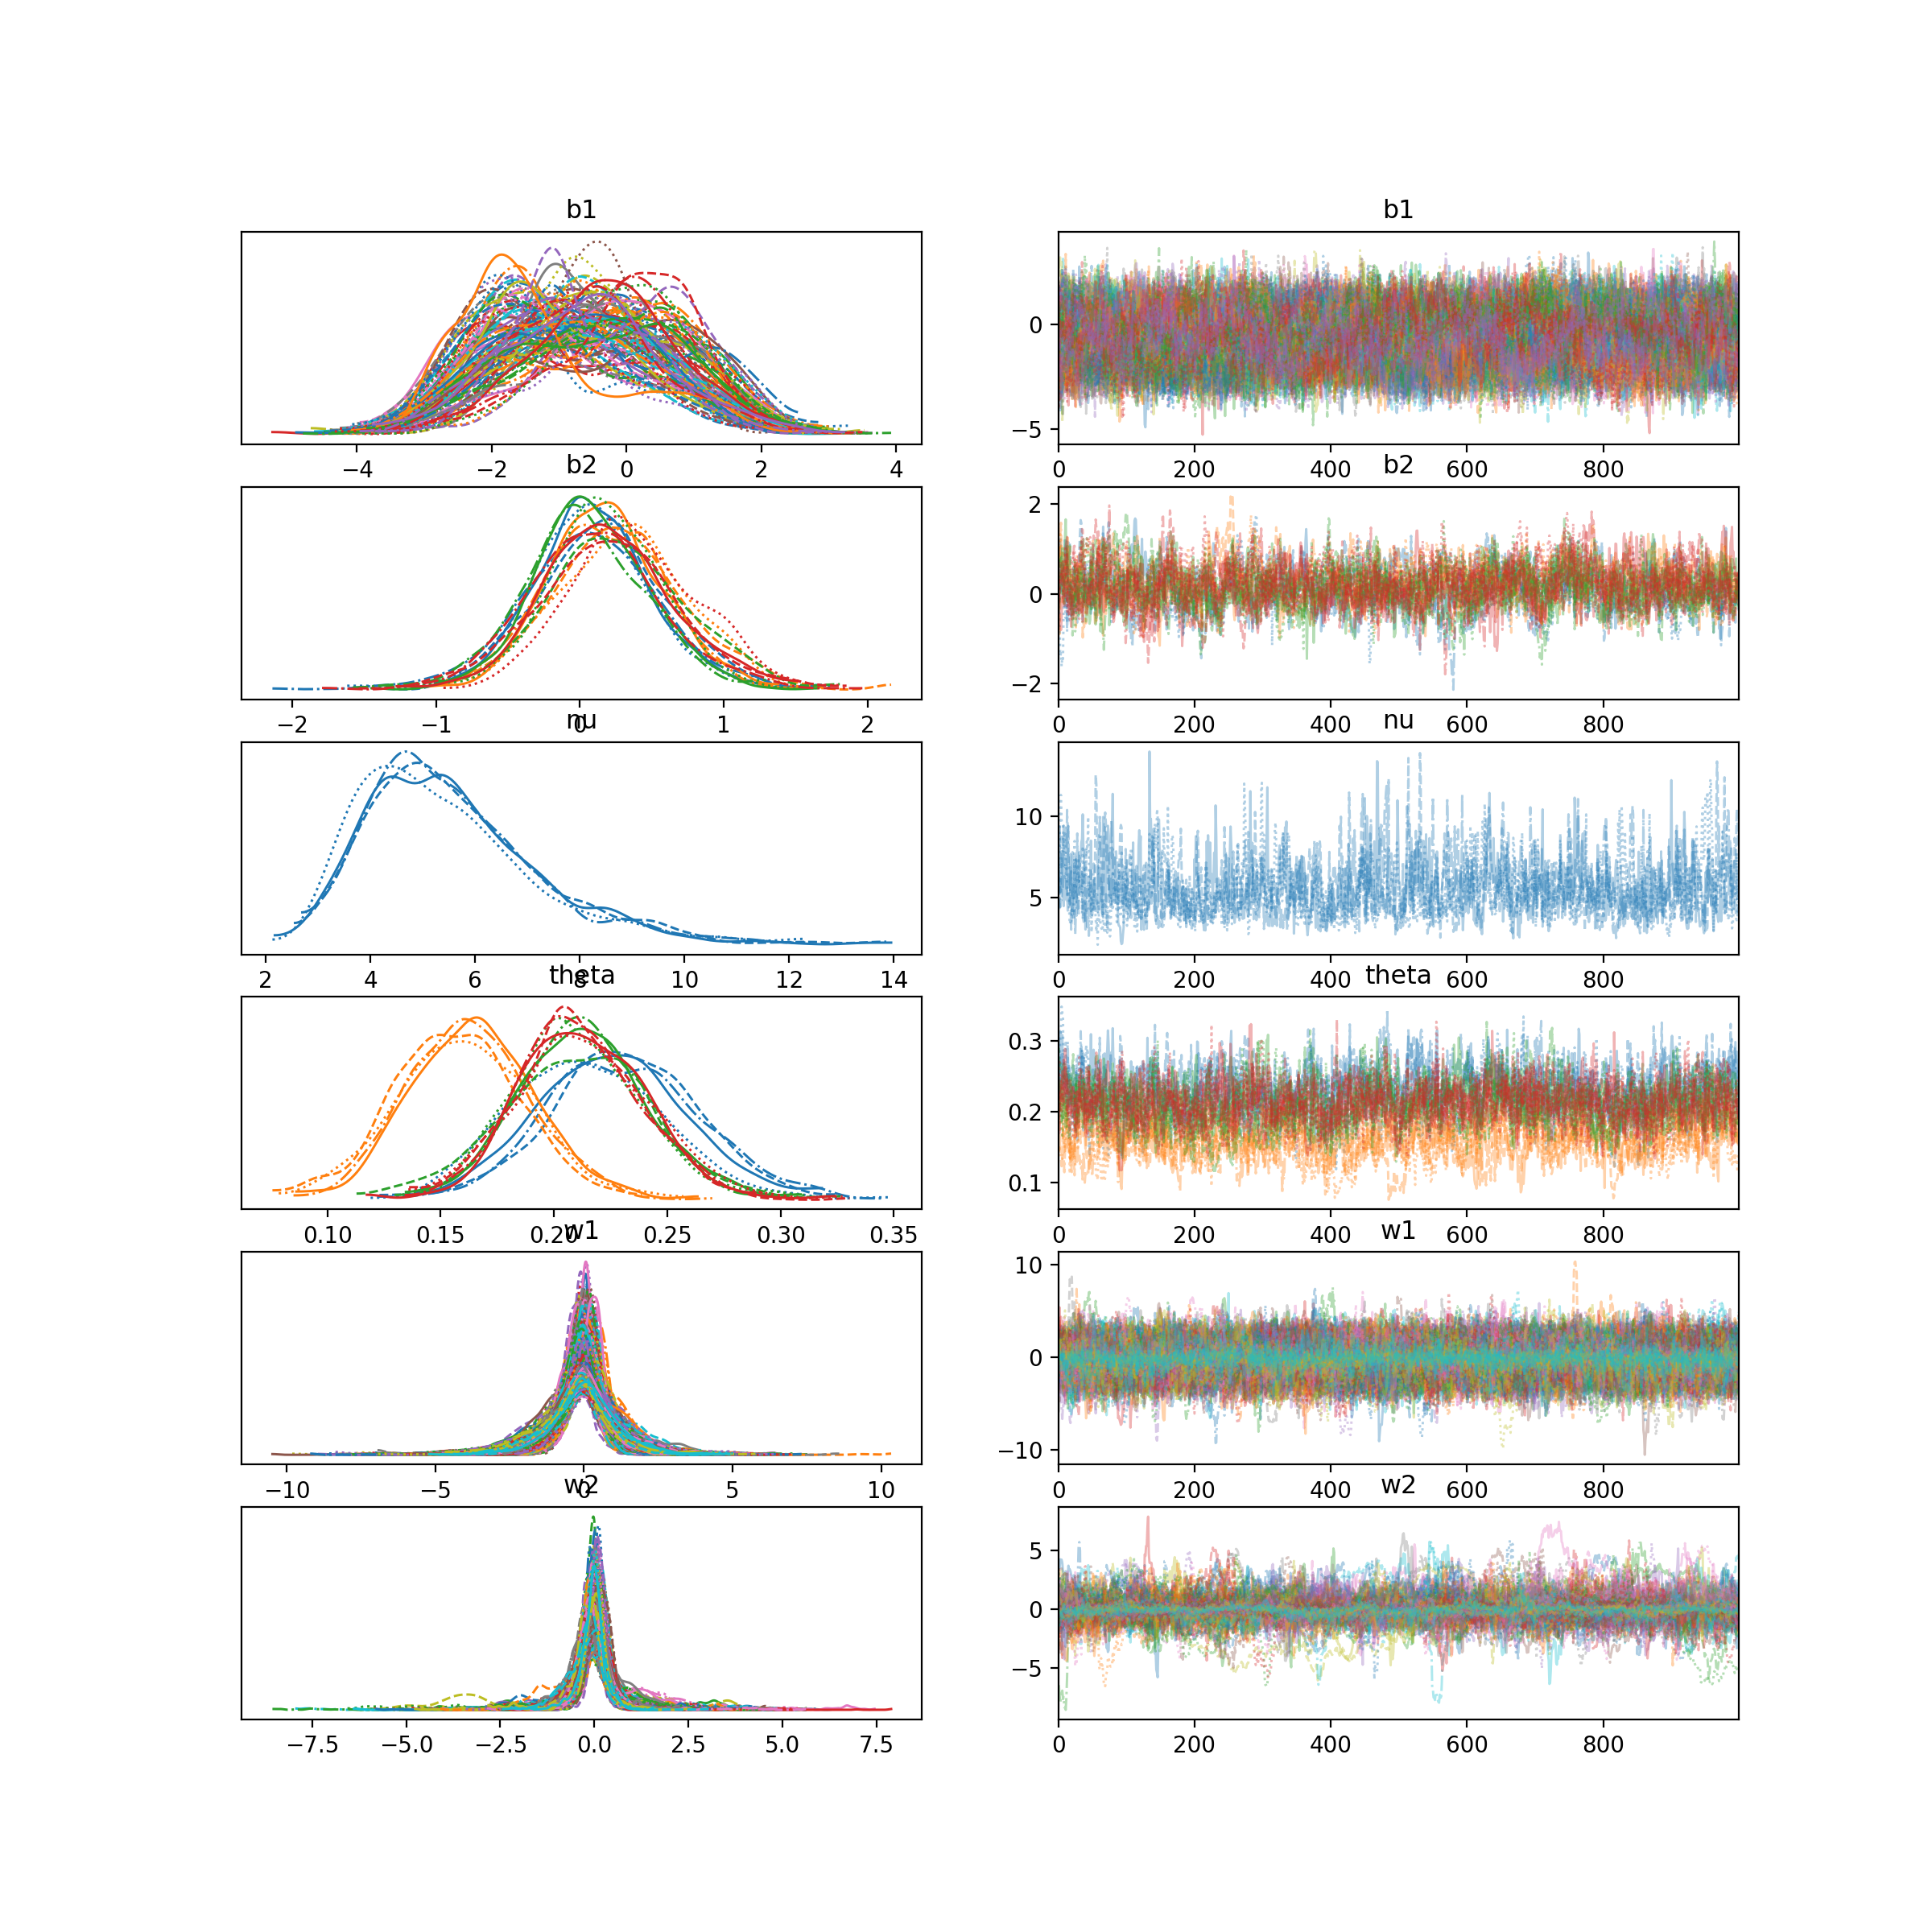

In [9]:
from matplotlib import pyplot as plt

plt.show()